# Import Libraries

In [ ]:
import numpy as np
import json
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Import Data

In [2]:
file_path = "features-Master.csv"

# Load the data
data = pd.read_csv(file_path)
data.head()

,Participant,Stimulus,Epoch,Comfort Score,Fz_delta,F4_delta,F8_delta,C3_delta,Cz_delta,C4_delta,...,T8_SNR,P7_SNR,P3_SNR,P4_SNR,P8_SNR,PO7_SNR,PO8_SNR,O1_SNR,Oz_SNR,O2_SNR
0,sub-P001,Contrast1Size1,0,2,2.448824,2.735208,2.625825,0.667754,0.630366,0.600551,...,5.579797,4.563784,6.715668,1.686805,2.526394,6.401941,3.930841,9.300906,6.110192,7.194652
1,sub-P001,Contrast1Size1,1,1,2.723200,2.861303,2.246634,0.733556,0.685686,0.493758,...,8.894524,5.245286,2.709850,3.210986,-3.791832,6.823958,1.436615,10.252812,6.636663,10.002002
2,sub-P001,Contrast1Size1,2,1,0.840657,0.951815,0.736841,0.271587,0.350219,0.467871,...,8.939924,8.248853,1.931214,2.975159,3.053014,11.515247,5.612836,12.985643,10.439934,11.517924
3,sub-P001,Contrast1Size2,0,1,5.868285,6.187138,5.014753,1.567451,1.414178,1.212041,...,7.054707,4.390395,5.668877,4.628688,7.891783,8.157199,6.132167,9.166936,8.423541,10.037865
4,sub-P001,Contrast1Size2,1,1,2.086935,2.286884,2.068594,0.854915,0.736913,0.635946,...,3.732884,0.967964,-2.265710,-0.184491,-2.654641,2.717986,1.452653,5.397260,6.099019,6.456628


# Define Features and Labels

In [3]:
# Shuffle the data before splitting or training, keeping features and labels aligned
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Break into train/split 
- hardcode 80/20 for now
    * 400 total rows of data, use first 320 for training, last 80 for testing

In [ ]:
data_train = data_shuffled[:320]
data_test = data_shuffled[320:]
labels_train = labels_shuffled[:320]
labels_test = labels_shuffled[320:]

# Check distribution of labels

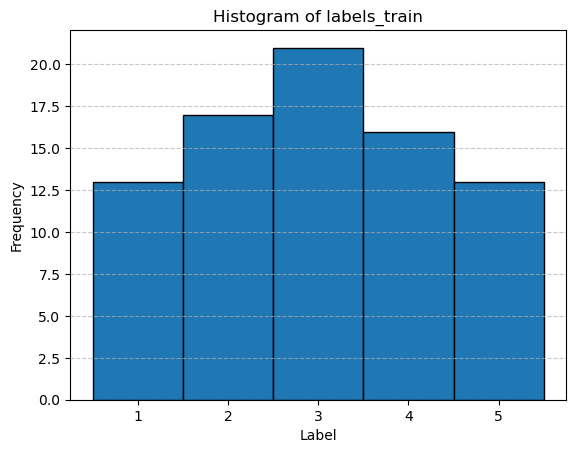

In [ ]:
# Plot histogram
plt.hist(labels_test, bins=range(min(labels_test), max(labels_test)+2), edgecolor='black', align='left')
plt.title('Histogram of labels_train')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(min(labels_test), max(labels_test)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Run Feature Selection
- https://github.com/smazzanti/mrmr 

## Compile data with only best N features
- Use or Not (don't throw away features)
- Make 'use_mrmr' a hyperparameter

# Seaborn Pair Plot
- Visual how comfort scores (y_values) vary with different feature values
- If a particular feature is highly correlated with the y_values, that is a good feature

# Optimize hyperparameters
- Use CV hyperparameters
- Preprocessing steps
- Feature selection

## CV Hyperparameters

In [ ]:
# Set parameters for Cross validation
params = {
    'iterations': 350, # trial.suggest(5, 500) [example, not real values]
    'learning_rate': 0.03,
    'depth': 4,
    'l2_leaf_reg': 10,
    'loss_function': 'RMSE',
    'verbose': False,
    'random_seed': 42
}

# Run Cross-Validation 
train_pool = Pool(data_train, labels_train)
cv_results = cv(train_pool, params, fold_count=5, early_stopping_rounds=10, plot=True)

## PUT ABOVE CODE inside optuna objective object
# Output = optimize the mean CV accuracy, r2, RMSE

# Print final test RMSE
print(f"CV RMSE: {cv_results['test-RMSE-mean'].values[-1]:.4f}")

## Feature Selection

## Preproccesing (Options at this point)

# Regression Model

In [ ]:
# Train final model on full dataset 
model = CatBoostRegressor(**params)
model.fit(data_train, labels_train)

# Run Regression model
y_pred = model.predict(data_test)

# Calculate RMSE
rmse = mean_squared_error(labels_test, y_pred)
r2 = r2_score(labels_test, y_pred)

print(f"Reduced Model Test RMSE: {rmse:.4f}")
print(f"Reduced Model Test R²: {r2:.4f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.066543981
bestIteration = 228

Training on fold [1/5]

bestTest = 1.235814985
bestIteration = 134

Training on fold [2/5]

bestTest = 1.117110723
bestIteration = 189

Training on fold [3/5]

bestTest = 1.133937041
bestIteration = 199

Training on fold [4/5]

bestTest = 1.182290848
bestIteration = 324

CV RMSE: 1.1480

Top 10 Important Features:
            feature  importance
223   O2_abs_fft_10    8.813083
221   O1_abs_fft_10    5.376800
325          C4_SNR    4.041389
326          T8_SNR    2.317003
285  O1_norm_fft_10    2.202012
238   Oz_abs_fft_20    1.872423
12        PO8_delta    1.848295
233   P4_abs_fft_20    1.763739
303  O2_norm_fft_20    1.495873
297  P4_norm_fft_20    1.476914
Reduced Model Test RMSE: 1.3643
Reduced Model Test R²: 0.2033


# To know whether this actually works
- feature selection 
    - https://github.com/smazzanti/mrmr 
    - or also use optuna "use this feature yes or no", filter out features that return No
- hyperparameter optimization
    - https://optuna.org/
        - for all of the points in the model where I am not sure what to do, call this
        - make sure to know the variable you are optimizing
            - here, want to optimize the mean CV accuracy, r2, RMSE
        - do a CV inside of this

- check distribution of y values

- reduce feature count
    - BEFORE CV
    - https://github.com/smazzanti/mrmr 
    - start w 5 and increase
- run again, if it needs 300+ features to get to this point, something is wrong


- classification 
    - distribution of y values [class imbalance]
    - stratified k-fold CV (sci-kit) 
        - makes it so there is an equal distribution of all classes

- visualize data
    - features
    - y values (seaborn- pair plot)
        - how do features vary with the y values